# DQN for TIC-TAC-TOE

As a first attempt, we might convert the input state-action pairs to a binary representation and use a linear output for the Q value.

We would use a one-hot representation for each of the 9 game cells in s (3 choices) and the 9 possible actions. This would give us 36 inputs.

The neural network would be multi-layer. With two fully connected layers of 10 units each, we'd have 10x37+10x11+11=491 parameters.

However, take a look at DQN. Their model has a NN to process the input images from the Atari console and has one output for each possible action.

With this approach, we would have just 27 inputs and 9 outputs.

Two fully connected layers of 10 units each would give us 10 x 28 + 10 x 11 + 9 x 11 = 489 parameters, which is similar in size to the above and has the advantage of only
having to be executed once to get the value of every action.

So, the first step will be to replace the Q table with a Q network. Go ahead and write your network class in PyTorch.


Deep Q-Learning

Alright, you have a neural network to replace the Q table, but how to learn its parameters?

Take a look again at Mnih et al. (2015). The method they recommend is experience replay in which they store recent state-action-reward tuples in a buffer and train on random subsamples from the buffer.

You'll have to decide some things, such as what to do if the agent samples an illegal move. Give a negative reward? Give a 0 reward? Think about it and try an approach.

Go ahead and write the DQN algorithm, using your simple fully connected network in place of the CNN. Get it learning!

Report on your experiments and results by next week.

In [1]:
import math, random
import importlib
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np
import os

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = 'cpu'

In [2]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 


def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [3]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [16]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=n_state, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=n_action))
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.Tensor(state).unsqueeze(0)).to(device)
#             print(state.shape)
            q_value = self.forward(state)
            q_value = q_value.cpu()
#             print(q_value.shape)
            action = q_value.max(1)[1].item()            
        else: # get random action
#             action = random.randrange(env.action_space.n)
            action = random.randrange(9)
        return action
    
    def get_q_value(self, state):
        state = autograd.Variable(torch.Tensor(state).unsqueeze(0)).to(device)
#             print(state.shape)
        q_value = self.forward(state)
        q_value = q_value.cpu()
#             print(q_value.shape)
        action = q_value.max(1)[1].item() 
        
        return q_value, action
        

In [5]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = torch.Tensor(np.float32(state)).to(device)
    next_state = torch.Tensor(np.float32(next_state)).to(device)
    action     = torch.Tensor(action).long().to(device)
    reward     = torch.Tensor(reward).to(device)
    done       = torch.Tensor(done).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    next_q_values = model(next_state)
    
#     print(q_values.shape)

    # Get Q(s,a) and max_a' Q(s',a')
#     q_value          = q_values.gather(1, action).squeeze(1)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [6]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()
    state = state.reshape(27)

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        state = state.reshape(27)
        
        action = model.act(state, epsilon)
        
        # Take a step
#         next_state, reward, done, _ = env.step(action)
        next_state, reward, done = env.step(action)
        next_state = next_state.reshape(27)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model, all_rewards, losses

In [7]:
from games.abstract_game import AbstractGame

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name) 

env = game_module.Game()

model = DQN(27, 9).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [8]:
env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

Agent training (episode1000001) Avg Reward 0.17766682233317765: 100%|██████| 1000001/1000001 [2:51:30<00:00, 97.18it/s]


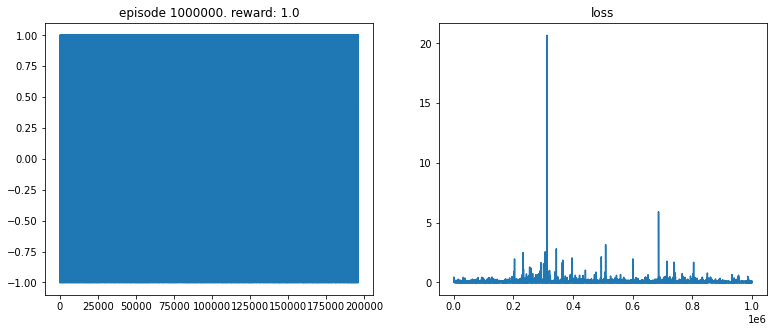

In [9]:
model, all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 1000000, batch_size=32, gamma = 0.99)
torch.save(model.state_dict(), 'weights/tictactoe-fcdqn-1M.pth')

In [10]:
import time
def play_game(model):
    done = False
    state = env.reset()
    state = state.reshape(27)

    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done = env.step(action)
        next_state = next_state.reshape(27)

        env.render()
        time.sleep(0.03)
        state = next_state

play_game(model)
time.sleep(3)
env.close()

   |   |   
---+---+---
   |   |   
---+---+---
   | O |   
   |   |   
---+---+---
   |   | X 
---+---+---
   | O |   
   | O |   
---+---+---
   |   | X 
---+---+---
   | O |   
 X | O |   
---+---+---
   |   | X 
---+---+---
   | O |   
 X | O |   
---+---+---
   | O | X 
---+---+---
   | O |   


# Load & Try the model with these patterns

In [17]:
import math, random
import importlib
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np
import os

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = 'cpu'
epsilon_final = 0.01

from games.abstract_game import AbstractGame

game_name = 'tictactoe'
game_module = importlib.import_module("games." + game_name) 

env = game_module.Game()

model = DQN(27, 9).to(device)
model.load_state_dict(torch.load('weights/tictactoe-fcdqn-1M.pth', map_location=torch.device('cpu') ),)
model.eval()

DQN(
  (layers): Sequential(
    (0): Linear(in_features=27, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=9, bias=True)
  )
)

In [28]:
state = env.reset()
state = state.reshape(27)

# create the first state
state, reward, done = env.step(0)
env.render()

state = state.reshape(27)

q_value, action = model.get_q_value(state)

print(q_value.shape)
print(q_value[0][4])
print(q_value[0][5])

# next_state, reward, done = env.step(5)
# print(next_state, 'reward', reward, 'is_done:', done)

# action = model.act(state, epsilon_final)
# next_state, reward, done = env.step(action)
# next_state = next_state.reshape(27)

 O |   |   
---+---+---
   |   |   
---+---+---
   |   |   
torch.Size([1, 9])
tensor(-0.7885, grad_fn=<SelectBackward>)
tensor(-0.8351, grad_fn=<SelectBackward>)
